In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet_v2 import Resnet4Channel

In [3]:
gpu_device = 0

defaults.device = torch.device(f'cuda:{gpu_device}')
torch.cuda.set_device(gpu_device)

In [4]:
import pretrainedmodels

In [5]:
print(pretrainedmodels.model_names)

['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [6]:
print(pretrainedmodels.pretrained_settings['se_resnext50_32x4d'])

{'imagenet': {'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth', 'input_space': 'RGB', 'input_size': [3, 224, 224], 'input_range': [0, 1], 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'num_classes': 1000}}


In [7]:
path = Path('/home/haider/data/human_protein_atlas/')

In [8]:
df = pd.read_csv(path/'train.csv')
df_extra = pd.read_csv(path/'HPAv18RBGY_wodpl.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


Visualizing : https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

In [9]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [10]:
train_labels = df.copy(0)

for key in label_names.keys():
    train_labels[label_names[key]] = 0
    
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()


,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


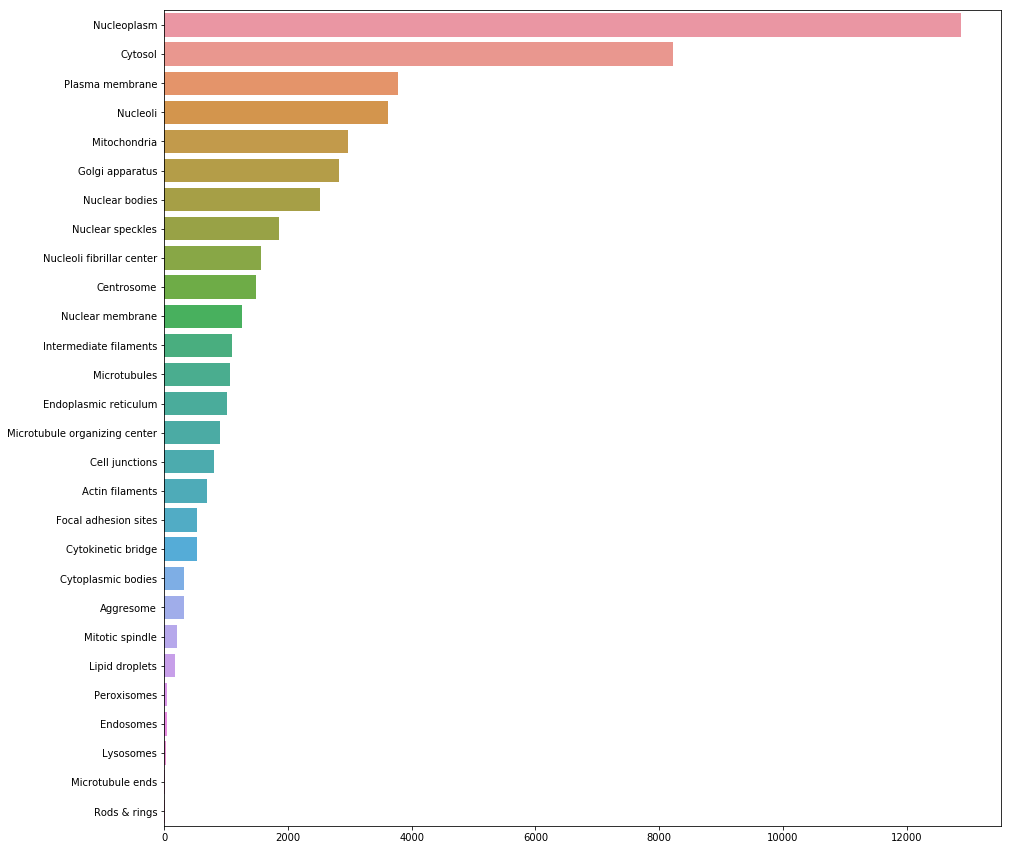

In [11]:
import seaborn as sns

target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

Oversampling using Brian code FROM THE EXTRA DATASET : https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/75691#446302

In [12]:
#train_df_orig=df.copy()    
lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]
for i in lows:
    target = str(i)
    indicies = df_extra.loc[df_extra['Target'] == target].index
    df = pd.concat([df,df_extra.loc[indicies]], ignore_index=True)
    indicies = df_extra.loc[df_extra['Target'].str.startswith(target+" ")].index
    df = pd.concat([df,df_extra.loc[indicies]], ignore_index=True)
    indicies = df_extra.loc[df_extra['Target'].str.endswith(" "+target)].index
    df = pd.concat([df,df_extra.loc[indicies]], ignore_index=True)
    indicies = df_extra.loc[df_extra['Target'].str.contains(" "+target+" ")].index
    df = pd.concat([df,df_extra.loc[indicies]], ignore_index=True)

In [13]:
train_labels = df.copy(0)

for key in label_names.keys():
    train_labels[label_names[key]] = 0
    
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()


,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


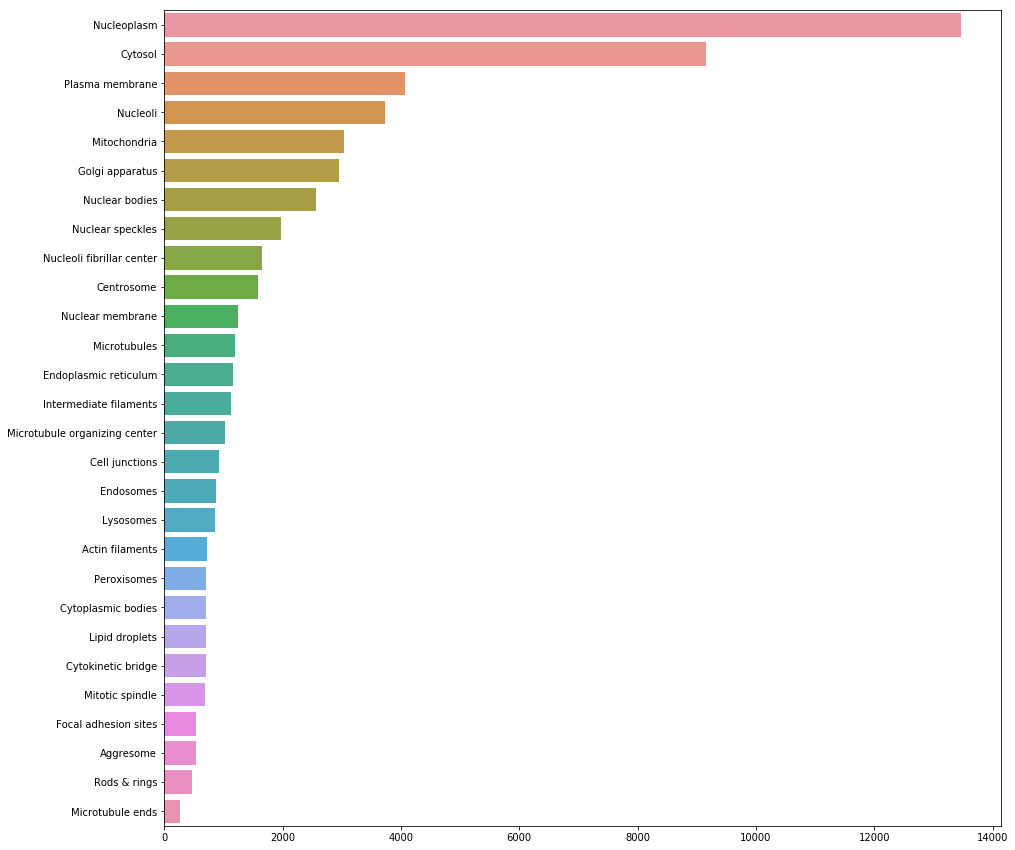

In [14]:
import seaborn as sns

target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

In [15]:
# im_count = df.Id.value_counts()
# im_count.name = 'sighting_count'
# df = df.join(im_count, on='Id')
# val_fns = set(df.sample(frac=1).groupby('Id').first().Image)

In [16]:
# fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}

In [17]:
# path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

In [18]:
path

PosixPath('/home/haider/data/human_protein_atlas')

In [19]:
np.random.seed(302)
src = (ImageItemList.from_df(df, path=path/'train_both', suffix='.png', cols=['Id'])
       .random_split_by_pct(0.2)
       .label_from_df(cols=['Target'], sep=' ',  classes=[str(i) for i in range(28)]))

In [20]:
# data = (
#     ImageItemList
#         .from_df(df[df.Id != 'new_whale'], 'data/train', cols=['Image'])
#         .split_by_valid_func(lambda path: path2fn(path) in val_fns)
#         .label_from_func(lambda path: fn2label[path2fn(path)])
#         .add_test(ImageItemList.from_folder('data/test'))
#         .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
#         .normalize(imagenet_stats)
# )

In [21]:
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [22]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [23]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [24]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [25]:
test_fnames[:5]

[PosixPath('/home/haider/data/human_protein_atlas/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/haider/data/human_protein_atlas/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [26]:
src.add_test(test_fnames, label='0');

In [27]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [28]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [29]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [30]:
src.train.x

ImageItemList (27965 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train_both

In [31]:
src.valid.x

ImageItemList (6991 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train_both

total train+valid dataset = 34956 . while before oversampling it was 31072

In [32]:
NUM_WORKERS = 8
BS = 64//4

In [33]:
data = (src.transform((trn_tfms, _), size=512)
        .databunch(bs=BS, num_workers=NUM_WORKERS).normalize(protein_stats))

#        .normalize(imagenet_stats)

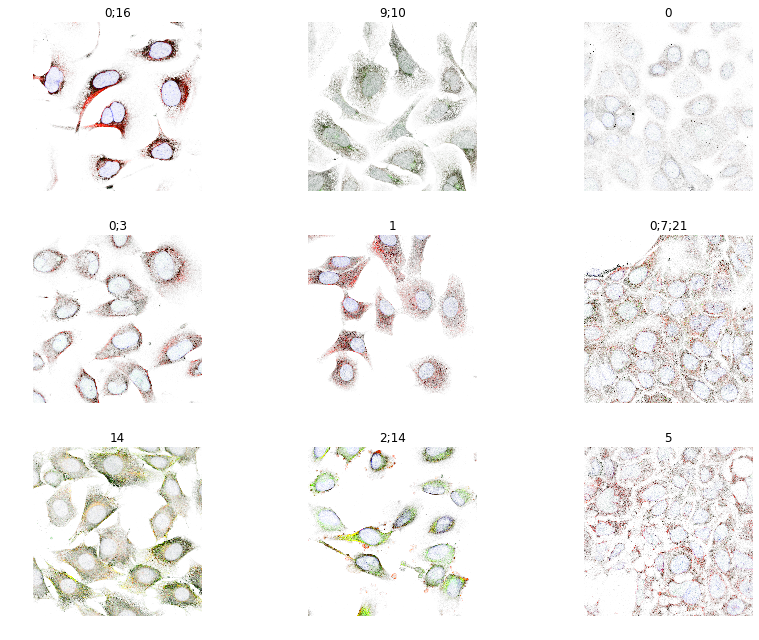

In [34]:
data.show_batch(rows=3, figsize=(12,9))

In [79]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [80]:
# copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): 
    # import pdb; pdb.set_trace()  ; m[0] returns the body ; m[0][6] returns the 7th block of the body ; m[1] returns the head; 
    # so it seems this function specifies the points that divides the 3 groups for the differential learning rates
    return (m[0][6],m[1])

In [81]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [82]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [83]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


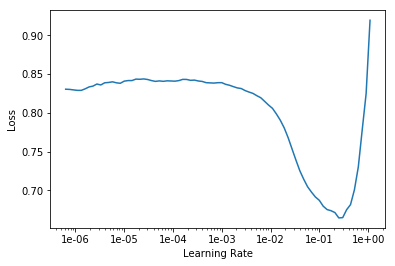

In [84]:
learn.recorder.plot()

In [85]:
lr = 3e-2/4

In [86]:
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.145480,0.132804,0.525979
2,0.125928,0.115635,0.612130
3,0.120589,0.105065,0.647879
4,0.115861,0.101255,0.658030
5,0.110124,0.096077,0.687476


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [87]:
learn.save('stage-1-rn50-datablocks_rn50_sz512-os-from-extrads')

In [88]:
learn.load('stage-1-rn50-datablocks_rn50_sz512-os-from-extrads')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (27965 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: /home/haider/data/human_protein_atlas/train_both
x: ImageItemList (27965 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train_both;

Valid: LabelList
y: MultiCategoryList (6991 items)
[MultiCategory 25, MultiCategory 25;14;17;2, MultiCategory 0, MultiCategory 26;5;0, MultiCategory 3]...
Path: /home/haider/data/human_protein_atlas/train_both
x: ImageItemList (6991 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: /home/haider/data/human_protein_atlas/train_both;

Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: /home/haider/da

In [89]:
learn.unfreeze()

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


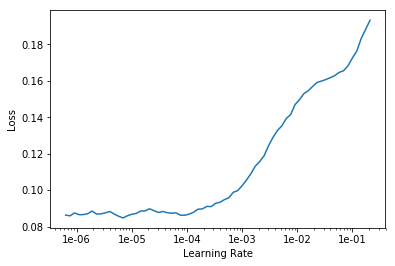

In [91]:
learn.recorder.plot()

In [92]:
learn.fit_one_cycle(20, slice(3e-5/4, lr/5))

epoch,train_loss,valid_loss,fbeta
1,0.093807,0.084603,0.725390
2,0.098191,0.085919,0.719467
3,0.097925,0.089121,0.711358
4,0.095345,0.093757,0.692522
5,0.095497,0.088014,0.711666
6,0.097075,0.087306,0.709542
7,0.089248,0.083920,0.730562
8,0.088413,0.078980,0.737510
9,0.082751,0.079393,0.736563
10,0.082405,0.075051,0.753106


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [95]:
learn.recorder.metrics

[[tensor(0.7254)],
 [tensor(0.7195)],
 [tensor(0.7114)],
 [tensor(0.6925)],
 [tensor(0.7117)],
 [tensor(0.7095)],
 [tensor(0.7306)],
 [tensor(0.7375)],
 [tensor(0.7366)],
 [tensor(0.7531)],
 [tensor(0.7576)],
 [tensor(0.7661)],
 [tensor(0.7708)],
 [tensor(0.7773)],
 [tensor(0.7782)],
 [tensor(0.7794)],
 [tensor(0.7870)],
 [tensor(0.7869)],
 [tensor(0.7900)],
 [tensor(0.7901)]]

In [93]:
learn.save('stage-2-rn50_sz512-os-from-extrads')

In [94]:
preds,y = learn.get_preds(DatasetType.Valid)
# y = to_np(y)
# preds = np.stack(preds, axis=-1)
# pred = preds.mean(axis=-1)  # This need when in fastai0.7 used TTA
pred = preds

## Iafoss thresholds and other tweaking methods below

In [118]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
# Instead of 0.5, one can adjust the values of the threshold for each class individually to boost the score. 
# The code below does it automatically.

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

def F1_soft(preds,targs,th=0.0,d=25.0):
#     preds = to_np(preds)
    preds = sigmoid_np(d*(preds - th))
#     targs = to_np(targs)
#     targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0, wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [119]:
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [120]:
th = fit_val(pred,y)
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

TypeError: sub(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [117]:
%debug


> <ipython-input-116-3f10e2ec51e8>(3)<module>()
      1 th = fit_val(pred,y)
      2 print('Thresholds: ',th)
----> 3 print('F1 macro: ',f1_score(y, pred>th[:, None], average='macro'))
      4 print('F1 macro (th = 0.0): ',f1_score(y, pred>0.0, average='macro'))
      5 print('F1 micro: ',f1_score(y, pred>th, average='micro'))



ipdb>  u


*** Oldest frame


ipdb>  d


*** Newest frame


ipdb>  exit


Using CV to prevent overfitting the thresholds:

In [ ]:
# This function is trying to minimize (F1-1)^2 + wd^2*th^2. So, you are trying to get F1 close to 1. 
# while if something goes wrong, like there are just a few data points, thresholds do not go far away from 0.0. 
# Also, I'm using a soft version of F1 to have stable gradient in least square minimization.

from sklearn.model_selection import train_test_split
th, score, cv = 0,0,10
for i in range(cv):
    xt,xv,yt,yv = train_test_split(pred,y,test_size=0.5,random_state=i)
    th_i = fit_val(xt,yt)
    th += th_i
    score += f1_score(yv, xv>th_i, average='macro')
th/=cv
score/=cv
print('Thresholds: ',th)
print('F1 macro avr:',score)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

In [ ]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > 0.5).mean(axis=0))

Plot the distribution of lables to see how the model performs. Be aware about log scale.

In [ ]:
f1 = f1_score(y, pred>th, average=None)
for i in range(len(name_label_dict)):
    bins = np.linspace(pred[:,i].min(), pred[:,i].max(), 50)
    plt.hist(pred[y[:,i] == 0][:,i], bins, alpha=0.5, log=True, label='false')
    plt.hist(pred[y[:,i] == 1][:,i], bins, alpha=0.5, log=True, label='true')
    plt.legend(loc='upper right')
    print(name_label_dict[i],i, f1[i], th[i])
    plt.axvline(x=th[i], color='k', linestyle='--')
    plt.show()

**Submission**

In [ ]:
preds_t,y_t = learn.get_preds(DatasetType.Test)
preds_t = np.stack(preds_t, axis=-1)
pred_t = preds_t.mean(axis=-1)

In [ ]:
def save_pred(pred, th=0.0, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
    
    df = pd.DataFrame({'Id':learner.data.test_ds.fnames,'Predicted':pred_list})
    df.sort_values(by='Id').to_csv(fname, header=True, index=False)

Save predictions for thresholds calculated based on the validation set and constant value 0.0:

In [ ]:
name = 'initialize_weight'

save_pred(pred_t,th,path/'subs'/f'{name}_v_th.csv')
save_pred(pred_t,0.0,path/'subs'/f'{name}_0_th.csv')

Similar to validation, additional adjustment may be done based on the public LB probing results (https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/68678) to predict approximately the same fraction of images of a particular class as expected from the public LB (I replaced 0 by 0.01 since there may be a rounding error leading to 0). Automatic fitting the thresholds based on the public LB statistics:

Haider Update: Turned out it is very similar to the fractions of the train set, so don't think it is useful

In [ ]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# I replaced 0 by 0.01 since there may be a rounding error leading to 0

In [ ]:
def Count_soft(preds,th=0.0,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = np.zeros(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*p), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [ ]:
th_t = fit_test(pred_t,lb_prob)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.0): ',(pred_t > 0.0).mean(axis=0))

In [ ]:
save_pred(pred_t,th_t,path/'subs'/f'{name}_f_th.csv')

Try using the threshold from validation set for classes not present in the public LB:

In [ ]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,path/'subs'/f'{name}_c_th.csv')

Try fitting thresholds based on the frequency of classes in the train dataset:

In [ ]:
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

In [ ]:
th_t = fit_test(pred_t,label_fraction)
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,path/'subs'/f'{name}_t_th.csv')

Brian's single threshold method

In [135]:
y

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [38]:
# !conda install -c anaconda scikit-learn -y

Solving environment: done

## Package Plan ##

  environment location: /home/haider/anaconda3/envs/fastai-v1

  added / updated specs: 
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1              |       h7b6447c_0         5.0 MB  anaconda
    scikit-learn-0.20.1        |   py37h4989274_0         5.7 MB  anaconda
    ca-certificates-2018.03.07 |                0         124 KB  anaconda
    certifi-2018.10.15         |           py37_0         138 KB  anaconda
    ------------------------------------------------------------
                                           Total:        10.9 MB

The following NEW packages will be INSTALLED:

    scikit-learn:    0.20.1-py37h4989274_0 anaconda

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0                   --> 2018.03.07-0      anaconda
    openssl:         1.1.1a-h7b6447c_0      

In [96]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

# preds_y = model.predict(valid_x) # in his code mine is : preds_y -> preds; valid_y -> y

thresholds = np.linspace(0, 1, 1500)
score = 0.0
best_threshold=0.0
best_val = 0.0
for threshold in thresholds:
    score = f1_score(y > 0.5, preds > threshold, average='macro')
    if score > best_val:
        best_threshold = threshold
        best_val = score
    print("Threshold %0.4f, F1: %0.4f" % (threshold,score))

print("BEST: %0.5f, F1: %0.5f" % (best_threshold,best_val))



Threshold 0.0000, F1: 0.1042
Threshold 0.0007, F1: 0.2535
Threshold 0.0013, F1: 0.3028
Threshold 0.0020, F1: 0.3344
Threshold 0.0027, F1: 0.3595
Threshold 0.0033, F1: 0.3799
Threshold 0.0040, F1: 0.3965
Threshold 0.0047, F1: 0.4123
Threshold 0.0053, F1: 0.4253
Threshold 0.0060, F1: 0.4370
Threshold 0.0067, F1: 0.4477
Threshold 0.0073, F1: 0.4575
Threshold 0.0080, F1: 0.4669
Threshold 0.0087, F1: 0.4744
Threshold 0.0093, F1: 0.4832
Threshold 0.0100, F1: 0.4912
Threshold 0.0107, F1: 0.4984
Threshold 0.0113, F1: 0.5060
Threshold 0.0120, F1: 0.5128
Threshold 0.0127, F1: 0.5193
Threshold 0.0133, F1: 0.5250
Threshold 0.0140, F1: 0.5298
Threshold 0.0147, F1: 0.5345
Threshold 0.0153, F1: 0.5401
Threshold 0.0160, F1: 0.5448
Threshold 0.0167, F1: 0.5493
Threshold 0.0173, F1: 0.5536
Threshold 0.0180, F1: 0.5573
Threshold 0.0187, F1: 0.5615
Threshold 0.0193, F1: 0.5658
Threshold 0.0200, F1: 0.5701
Threshold 0.0207, F1: 0.5743
Threshold 0.0213, F1: 0.5785
Threshold 0.0220, F1: 0.5830
Threshold 0.02

/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold 0.9947, F1: 0.2630
Threshold 0.9953, F1: 0.2493
Threshold 0.9960, F1: 0.2359
Threshold 0.9967, F1: 0.2205
Threshold 0.9973, F1: 0.2032
Threshold 0.9980, F1: 0.1843
Threshold 0.9987, F1: 0.1630
Threshold 0.9993, F1: 0.1233
Threshold 1.0000, F1: 0.0000
BEST: 0.31154, F1: 0.78667


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

## Brian's method to calculate thresholds

In [97]:
preds_np= to_np(preds)

thresholds = np.linspace(0, 1, 100)
score = 0.0
test_threshold=0.5*np.ones(28)
best_threshold=np.zeros(28)
best_val = np.zeros(28)
for i in range(28):
    for threshold in thresholds:
        test_threshold[i] = threshold
        # max_val = np.max(preds)
        # import pdb; pdb.set_trace()
        val_predict = (preds_np > test_threshold)
        score = f1_score(y > 0.5, val_predict, average='macro')
        if score > best_val[i]:
            best_threshold[i] = threshold
            best_val[i] = score

    print("Threshold[%d] %0.6f, F1: %0.6f" % (i,best_threshold[i],best_val[i]))
    test_threshold[i] = best_threshold[i]
print("Best threshold: ")
print(best_threshold)
print("Best f1:")
print(best_val)

/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[0] 0.292929, F1: 0.772014


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[1] 0.404040, F1: 0.772494


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[2] 0.414141, F1: 0.772671


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[3] 0.212121, F1: 0.773594


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[4] 0.404040, F1: 0.773686


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[5] 0.393939, F1: 0.774228


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[6] 0.353535, F1: 0.775724


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[7] 0.333333, F1: 0.776447


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[8] 0.181818, F1: 0.776682


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[9] 0.636364, F1: 0.777060


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[10] 0.676768, F1: 0.777337


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[11] 0.393939, F1: 0.777877


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[12] 0.393939, F1: 0.778633


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[13] 0.232323, F1: 0.780684


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[14] 0.454545, F1: 0.780886


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[15] 0.717172, F1: 0.781560


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[16] 0.454545, F1: 0.782319


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[17] 0.202020, F1: 0.782639


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

Threshold[18] 0.414141, F1: 0.783230


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[19] 0.343434, F1: 0.785795


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[20] 0.272727, F1: 0.787419


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[21] 0.313131, F1: 0.788439


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[22] 0.262626, F1: 0.790024


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[23] 0.292929, F1: 0.791536


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[24] 0.444444, F1: 0.792700


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[25] 0.323232, F1: 0.793984


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Threshold[26] 0.292929, F1: 0.795920
Threshold[27] 0.080808, F1: 0.796907
Best threshold: 
[0.292929 0.40404  0.414141 0.212121 0.40404  0.393939 0.353535 0.333333 0.181818 0.636364 0.676768 0.393939 0.393939
 0.232323 0.454545 0.717172 0.454545 0.20202  0.414141 0.343434 0.272727 0.313131 0.262626 0.292929 0.444444 0.323232
 0.292929 0.080808]
Best f1:
[0.772014 0.772494 0.772671 0.773594 0.773686 0.774228 0.775724 0.776447 0.776682 0.77706  0.777337 0.777877 0.778633
 0.780684 0.780886 0.78156  0.782319 0.782639 0.78323  0.785795 0.787419 0.788439 0.790024 0.791536 0.7927   0.793984
 0.79592  0.796907]


/home/haider/anaconda3/envs/fastai-v1/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
best_threshold

array([0.292929, 0.40404 , 0.414141, 0.212121, 0.40404 , 0.393939, 0.353535, 0.333333, 0.181818, 0.636364, 0.676768,
       0.393939, 0.393939, 0.232323, 0.454545, 0.717172, 0.454545, 0.20202 , 0.414141, 0.343434, 0.272727, 0.313131,
       0.262626, 0.292929, 0.444444, 0.323232, 0.292929, 0.080808])

**Submission**

In [99]:
name = 'stage-2-rn50_sz512-os-from-extrads'

preds_t,_ = learn.get_preds(DatasetType.Test)
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>best_threshold)[0]])) for row in np.array(preds_t)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [ ]:
# Horton's preds with fixed thresholds:

In [34]:
# preds,_ = learn.get_preds(DatasetType.Test)

In [54]:
## The chosen thresholds for all labels is set arbitrarly to 0.2

# name = 'baseline'

# pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
# df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
# df.to_csv(path/'subs'/f'{name}.csv', header=True, index=False)

In [155]:
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23


In [100]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f {path}/subs/{name}.csv -m "stage-2-rn50_sz512-os-from-extrads"

100%|████████████████████████████████████████| 469k/469k [00:06<00:00, 69.3kB/s]
Successfully submitted to Human Protein Atlas Image Classification